<!-- HTML file automatically generated from DocOnce source (https://github.com/doconce/doconce/)
doconce format html Project1.do.txt  -->
<!-- dom:TITLE: Project 1 on Machine Learning, deadline October 9 (midnight), 2023 -->

# Project 1 on Machine Learning, deadline October 9 (midnight), 2023
**[Data Analysis and Machine Learning FYS-STK3155/FYS4155](http://www.uio.no/studier/emner/matnat/fys/FYS3155/index-eng.html)**, University of Oslo, Norway

Date: **September 3**

## Regression analysis and resampling methods

The main aim of this project is to study in more detail various
regression methods, including the Ordinary Least Squares (OLS) method.
In addition to the scientific part, in this course we want also to
give you an experience in writing scientific reports.  The format for
the delivery of your answers is namely that of a scientific report. At
for example
<https://github.com/CompPhysics/MachineLearning/blob/master/doc/Projects/EvaluationGrading/EvaluationForm.md>
we detail how to write a report. Furthermore, at
<https://github.com/CompPhysics/MachineLearning/blob/master/doc/Projects/ReportExample/>
you can find examples of previous reports. How to write reports will
also be discussed during the various lab sessions.

**A small recommendation when developing the codes here**. Instead of
jumping on to the two-dimensional function described below, we
recommend to do the code development and testing with a simpler
one-dimensional function, similar to those discussed in the exercises
of weeks 35 and 36. A simple test, as discussed during the lectures the first
two weeks is to set the design matrix equal to the identity
matrix. Then your model should give a mean square error which is exactly equal to zero.
When you are sure that your codes function well, you can then replace
the one-dimensional test function with the two-dimensional **Franke** function
discussed here.

The Franke function serves as a stepping stone towards the analysis of
real topographic data. The latter is the last part of this project.

### Description of two-dimensional function

We will first study how to fit polynomials to a specific
two-dimensional function called [Franke's
function](http://www.dtic.mil/dtic/tr/fulltext/u2/a081688.pdf).  This
is a function which has been widely used when testing various
interpolation and fitting algorithms. Furthermore, after having
established the model and the method, we will employ resamling
techniques such as cross-validation and/or bootstrap in order to perform a
proper assessment of our models. We will also study in detail the
so-called Bias-Variance trade off.

The Franke function, which is a weighted sum of four exponentials  reads as follows

$$
\begin{align*}
f(x,y) &= \frac{3}{4}\exp{\left(-\frac{(9x-2)^2}{4} - \frac{(9y-2)^2}{4}\right)}+\frac{3}{4}\exp{\left(-\frac{(9x+1)^2}{49}- \frac{(9y+1)}{10}\right)} \\
&+\frac{1}{2}\exp{\left(-\frac{(9x-7)^2}{4} - \frac{(9y-3)^2}{4}\right)} -\frac{1}{5}\exp{\left(-(9x-4)^2 - (9y-7)^2\right) }.
\end{align*}
$$

The function will be defined for $x,y\in [0,1]$.  In a sense, our data are thus scaled to a particular domain for the input values.

Our first step will
be to perform an OLS regression analysis of this function, trying out
a polynomial fit with an $x$ and $y$ dependence of the form $[x, y,
x^2, y^2, xy, \dots]$. We will also include bootstrap first as a
resampling technique.  After that we will include the cross-validation
technique.

We can
use a uniform distribution to set up the arrays of values for $x$ and
$y$, or as in the example below just a set of fixed values for $x$ and
$y$ with a given step size.  We will fit a function (for example a
polynomial) of $x$ and $y$.  Thereafter we will repeat much of the
same procedure using the Ridge and Lasso regression methods,
introducing thus a dependence on the bias (penalty) $\lambda$.

Finally we are going to use (real) digital terrain data and try to
reproduce these data using the same methods. We will also try to go
beyond the second-order polynomials metioned above and explore 
which polynomial fits the data best.

The Python code for the Franke function is included here (it performs also a three-dimensional plot of it)

### Part a) : Ordinary Least Square (OLS) on the Franke function

We will generate our own dataset for a function
$\mathrm{FrankeFunction}(x,y)$ with $x,y \in [0,1]$. The function
$f(x,y)$ is the Franke function. You should explore also the addition
of an added stochastic noise to this function using the normal
distribution $N(0,1)$.

*Write your own code* (using either a matrix inversion or a singular
value decomposition from e.g., **numpy** ) and perform a standard **ordinary least square regression**
analysis using polynomials in $x$ and $y$ up to fifth order.

Evaluate the mean Squared error (MSE)

$$
MSE(\boldsymbol{y},\tilde{\boldsymbol{y}}) = \frac{1}{n}
\sum_{i=0}^{n-1}(y_i-\tilde{y}_i)^2,
$$

and the $R^2$ score function.  If $\tilde{\boldsymbol{y}}_i$ is the predicted
value of the $i-th$ sample and $y_i$ is the corresponding true value,
then the score $R^2$ is defined as

$$
R^2(\boldsymbol{y}, \tilde{\boldsymbol{y}}) = 1 - \frac{\sum_{i=0}^{n - 1} (y_i - \tilde{y}_i)^2}{\sum_{i=0}^{n - 1} (y_i - \bar{y})^2},
$$

where we have defined the mean value  of $\boldsymbol{y}$ as

$$
\bar{y} =  \frac{1}{n} \sum_{i=0}^{n - 1} y_i.
$$

Plot the resulting scores (MSE and R$^2$) as functions of the polynomial degree (here up to polymial degree five).
Plot also the parameters $\beta$ as you increase the order of the polynomial. Comment your results.

Your code has to include a scaling/centering of the data (for example by
subtracting the mean value), and
a split of the data in training and test data. For this exercise you can
either write your own code or use for example the function for
splitting training data provided by the library **Scikit-Learn** (make
sure you have installed it).  This function is called
$train\_test\_split$.  **You should present a critical discussion of why and how you have scaled or not scaled the data**.

It is normal in essentially all Machine Learning studies to split the
data in a training set and a test set (eventually  also an additional
validation set).  There
is no explicit recipe for how much data should be included as training
data and say test data.  An accepted rule of thumb is to use
approximately $2/3$ to $4/5$ of the data as training data.

You can easily reuse the solutions to your exercises from week 35 and week 36.
See also the lecture slides from week 35 and week 36.

[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.1  0.1
 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
 0.1  0.1  0.1  0.1  0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15
 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.2  0.2  0.2  0.2
 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2
 0.2  0.2  0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.3  0.3  0.3  0.3  0.3  0.3
 0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3
 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35
 0.35 0.35 0.35 0.35 0.35 0.35 0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4
 0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.45 0.45
 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45
 0.45 0.45 0.45

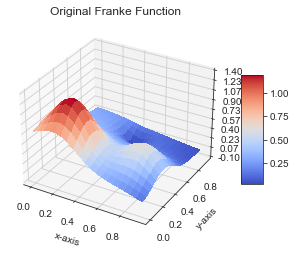

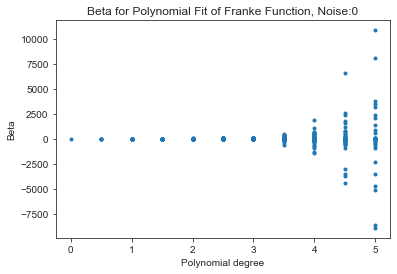

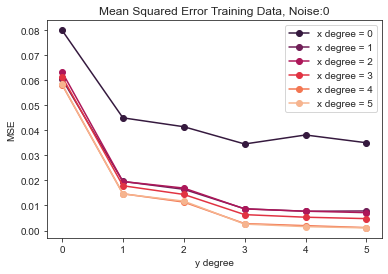

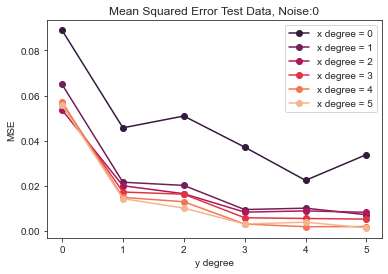

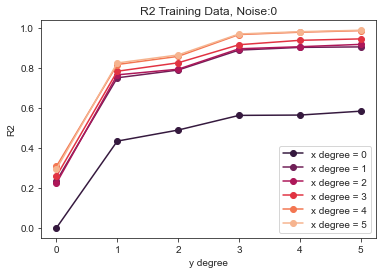

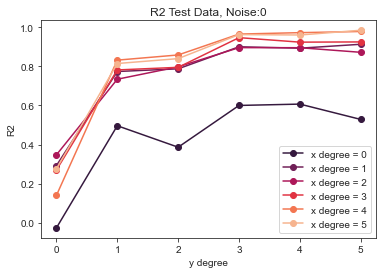

In [4]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set_style("ticks")
palette = sns.color_palette("tab10")
sns.set_palette(palette)

# Making the R2 and MSE functions
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)
def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

# Generating the data set
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x, y)
def FrankeFunction(x, y):
    term1 = 0.75 * np.exp(-(0.25 * (9 * x - 2) ** 2) - 0.25 * ((9 * y - 2) ** 2))
    term2 = 0.75 * np.exp(-((9 * x + 1) ** 2) / 49.0 - 0.1 * (9 * y + 1))
    term3 = 0.5 * np.exp(-(9 * x - 7) ** 2 / 4.0 - 0.25 * ((9 * y - 3) ** 2))
    term4 = -0.2 * np.exp(-(9 * x - 4) ** 2 - (9 * y - 7) ** 2)
    return term1 + term2 + term3 + term4

noise = 0
z = FrankeFunction(x, y) + noise * np.random.randn(20) # the additional term is the noise. Adjust the factor by a small number (<<1)

# Making the data into lists
x_flat = x.flatten()
y_flat = y.flatten()
z_flat = z.flatten()

#Plotting the original function
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
ax.set_title('Original Franke Function')
plt.show()

#Making lists with variables for the plotting
x_deg, y_deg, degree, MSE_train, MSE_test, R2_train, R2_test, beta_plot = [], [], [], [], [], [], [], []

def fit(degree_x, degree_y):
    #Making the design matrix
    X = np.zeros((len(x_flat), (degree_x+1)*(degree_y+1)))
    col_idx = 0
    for i in range(degree_x + 1):
        for j in range(degree_y + 1):
            X[:, col_idx] = x_flat**i * y_flat**j
            col_idx += 1
    #Plotting the fit (this is just to illustrate, not part of the exercise. Can therefore be removed)
    beta = np.linalg.inv(X.T @ X) @ X.T @ z_flat
    ztilde = X @ beta
    ztilde_grid = ztilde.reshape(x.shape)
    '''
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(projection='3d')
    surf = ax2.plot_surface(x, y, ztilde_grid, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    ax2.set_zlim(-0.10, 1.40)
    ax2.zaxis.set_major_locator(LinearLocator(10))
    ax2.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    fig2.colorbar(surf, shrink=0.5, aspect=5)
    ax2.set_xlabel('x-axis')
    ax2.set_ylabel('y-axis')
    ax2.set_zlabel('z-axis')
    ax2.set_title('Fitted Franke Function: Polynomial degree x' + str(degree_x)+ ', y'+ str(degree_y))
    plt.show()
    '''
    #Splitting into train and test
    X_train, X_test, z_train, z_test = train_test_split(X, z_flat, test_size=0.2)
    beta = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ z_train
    ztilde = X_train @ beta
    zpredict = X_test @ beta
    '''
    print('Polynomial degree x', str(degree_x), ', y', str(degree_y), ':')
    print('Beta:', beta)
    print("Training MSE: %.2f" % MSE(z_train, ztilde))
    print("Test MSE: %.2f" % MSE(z_test, zpredict))
    print('Training R2: %.2f' % R2(z_train, ztilde))
    print('Test R2: %.2f' % R2(z_test, zpredict))
    '''
    #Appending the variables to the lists for the plotting
    x_deg.append(int(degree_x))
    y_deg.append(int(degree_y))
    degree.append(int(degree_x + degree_y)/2)
    MSE_train.append(float(MSE(z_train, ztilde)))
    MSE_test.append(float(MSE(z_test, zpredict)))
    R2_train.append(float(R2(z_train, ztilde)))
    R2_test.append(float(R2(z_test, zpredict)))
    beta_plot.append(beta)

# Calling the different polynomial degrees
degree_x = [0,1,2,3,4,5]
degree_y = [0,1,2,3,4,5]
for i in range(len(degree_x)):
    for j in range(len(degree_y)):
        fit(degree_x[i], degree_y[j])

'''
#Plotting MSE
plt.plot(degree, MSE_train, 's', label = 'MSE train')
plt.plot(degree, MSE_test, 'o', label = 'MSE test')
plt.xlabel('Polynomial degree')
plt.ylabel('MSE')
plt.title('Mean Squared Error for Polynomial Fit of Franke Function, Noise:' + str(noise))
plt.legend()
plt.show()

#Plotting R2
plt.plot(degree, R2_train, 's', label = 'R2 train')
plt.plot(degree, R2_test, 'o', label = 'R2 test')
plt.xlabel('Polynomial degree')
plt.ylabel('R2')
plt.title('R2 for Polynomial Fit of Franke Function, Noise:' + str(noise))
plt.legend()
plt.show()
'''

#Plotting beta
plot_degree = []
plot_beta = []
for i in range(len(beta_plot)):
    for j in range(len(beta_plot[i])):
        plot_degree.append(degree[i])
        plot_beta.append(beta_plot[i][j])

plt.plot(plot_degree, plot_beta, '.')
plt.xlabel('Polynomial degree')
plt.ylabel('Beta')
plt.title('Beta for Polynomial Fit of Franke Function, Noise:' + str(noise))
plt.show()

palette = sns.color_palette("rocket")
sns.set_palette(palette)

for i in range(6):
    plt.plot(y_deg[6*i:6*(i+1)], MSE_train[6*i:6*(i+1)], marker = 'o', label = 'x degree = ' + str(i))
plt.xlabel('y degree')
plt.ylabel('MSE')
plt.title('Mean Squared Error Training Data, Noise:' + str(noise))
plt.legend()
plt.show()

for i in range(6):
    plt.plot(y_deg[6*i:6*(i+1)], MSE_test[6*i:6*(i+1)], marker = 'o', label = 'x degree = ' + str(i))
plt.xlabel('y degree')
plt.ylabel('MSE')
plt.title('Mean Squared Error Test Data, Noise:' + str(noise))
plt.legend()
plt.show()

for i in range(6):
    plt.plot(y_deg[6*i:6*(i+1)], R2_train[6*i:6*(i+1)], marker = 'o', label = 'x degree = ' + str(i))
plt.xlabel('y degree')
plt.ylabel('R2')
plt.title('R2 Training Data, Noise:' + str(noise))
plt.legend()
plt.show()

for i in range(6):
    plt.plot(y_deg[6*i:6*(i+1)], R2_test[6*i:6*(i+1)], marker = 'o', label = 'x degree = ' + str(i))
plt.xlabel('y degree')
plt.ylabel('R2')
plt.title('R2 Test Data, Noise:' + str(noise))
plt.legend()
plt.show()

### Part b): Adding Ridge regression for  the Franke function

Write your own code for the Ridge method, either using matrix
inversion or the singular value decomposition as done in the previous
exercise. The lecture notes from week 35 and 36 contain more information. Furthermore, the numerical exercise from week 36 is something you can reuse here.

Perform the same analysis as you did in the previous exercise but now for different values of $\lambda$. Compare and
analyze your results with those obtained in part a) with the ordinary least squares method. Study the
dependence on $\lambda$.

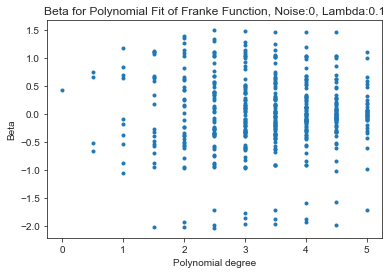

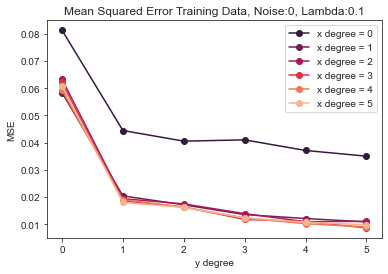

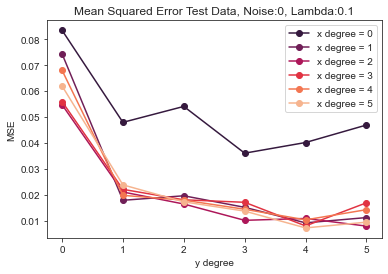

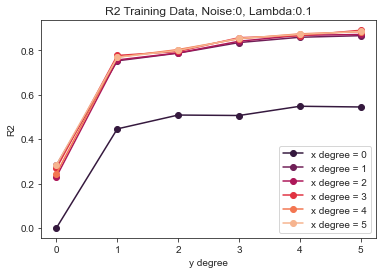

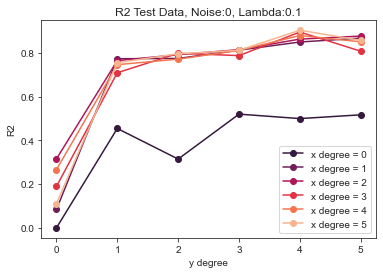

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set_style("ticks")
palette = sns.color_palette("tab10")
sns.set_palette(palette)

# Making the R2 and MSE functions
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)
def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

# Generating the data set
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x, y)
def FrankeFunction(x, y):
    term1 = 0.75 * np.exp(-(0.25 * (9 * x - 2) ** 2) - 0.25 * ((9 * y - 2) ** 2))
    term2 = 0.75 * np.exp(-((9 * x + 1) ** 2) / 49.0 - 0.1 * (9 * y + 1))
    term3 = 0.5 * np.exp(-(9 * x - 7) ** 2 / 4.0 - 0.25 * ((9 * y - 3) ** 2))
    term4 = -0.2 * np.exp(-(9 * x - 4) ** 2 - (9 * y - 7) ** 2)
    return term1 + term2 + term3 + term4

noise = 0
lmb = 0.1
z = FrankeFunction(x, y) + noise * np.random.randn(20) # the additional term is the noise. Adjust the factor by a small number (<<1)

# Making the data into lists
x_flat = x.flatten()
y_flat = y.flatten()
z_flat = z.flatten()

#Making lists with variables for the plotting
x_deg, y_deg, degree, MSE_train, MSE_test, R2_train, R2_test, beta_plot = [], [], [], [], [], [], [], []

def fit(degree_x, degree_y):
    
    #Making the design matrix
    X = np.zeros((len(x_flat), (degree_x+1)*(degree_y+1)))
    col_idx = 0
    for i in range(degree_x + 1):
        for j in range(degree_y + 1):
            X[:, col_idx] = x_flat**i * y_flat**j
            col_idx += 1

    #Splitting into train and test
    X_train, X_test, z_train, z_test = train_test_split(X, z_flat, test_size=0.2)
    
    #Ridge
    I = np.eye((degree_x+1)*(degree_y+1), (degree_x+1)*(degree_y+1))
    nlambdas = 5
    MSEPredict = np.zeros(nlambdas)
    MSETrain = np.zeros(nlambdas)
    Ridgebeta = np.linalg.inv(X_train.T @ X_train+lmb*I) @ X_train.T @ z_train
    ztildeRidge = X_train @ Ridgebeta
    zpredictRidge = X_test @ Ridgebeta
    
    #Appending the variables to the lists for the plotting
    x_deg.append(int(degree_x))
    y_deg.append(int(degree_y))
    degree.append(int(degree_x + degree_y)/2)
    MSE_train.append(float(MSE(z_train, ztildeRidge)))
    MSE_test.append(float(MSE(z_test, zpredictRidge)))
    R2_train.append(float(R2(z_train, ztildeRidge)))
    R2_test.append(float(R2(z_test, zpredictRidge)))
    beta_plot.append(Ridgebeta)

# Calling the different polynomial degrees
degree_x = [0,1,2,3,4,5]
degree_y = [0,1,2,3,4,5]
for i in range(len(degree_x)):
    for j in range(len(degree_y)):
        fit(degree_x[i], degree_y[j])

#Plotting beta
plot_degree = []
plot_beta = []
for i in range(len(beta_plot)):
    for j in range(len(beta_plot[i])):
        plot_degree.append(degree[i])
        plot_beta.append(beta_plot[i][j])

plt.plot(plot_degree, plot_beta, '.')
plt.xlabel('Polynomial degree')
plt.ylabel('Beta')
plt.title('Beta for Polynomial Fit of Franke Function, Noise:' + str(noise) + ', Lambda:' + str(lmb))
plt.show()

palette = sns.color_palette("rocket")
sns.set_palette(palette)

for i in range(6):
    plt.plot(y_deg[6*i:6*(i+1)], MSE_train[6*i:6*(i+1)], marker = 'o', label = 'x degree = ' + str(i))
plt.xlabel('y degree')
plt.ylabel('MSE')
plt.title('Mean Squared Error Training Data, Noise:' + str(noise) + ', Lambda:' + str(lmb))
plt.legend()
plt.show()

for i in range(6):
    plt.plot(y_deg[6*i:6*(i+1)], MSE_test[6*i:6*(i+1)], marker = 'o', label = 'x degree = ' + str(i))
plt.xlabel('y degree')
plt.ylabel('MSE')
plt.title('Mean Squared Error Test Data, Noise:' + str(noise) + ', Lambda:' + str(lmb))
plt.legend()
plt.show()

for i in range(6):
    plt.plot(y_deg[6*i:6*(i+1)], R2_train[6*i:6*(i+1)], marker = 'o', label = 'x degree = ' + str(i))
plt.xlabel('y degree')
plt.ylabel('R2')
plt.title('R2 Training Data, Noise:' + str(noise) + ', Lambda:' + str(lmb))
plt.legend()
plt.show()

for i in range(6):
    plt.plot(y_deg[6*i:6*(i+1)], R2_test[6*i:6*(i+1)], marker = 'o', label = 'x degree = ' + str(i))
plt.xlabel('y degree')
plt.ylabel('R2')
plt.title('R2 Test Data, Noise:' + str(noise) + ', Lambda:' + str(lmb))
plt.legend()
plt.show()

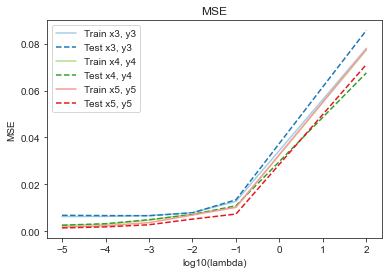

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set_style("ticks")
palette = sns.color_palette("Paired")
sns.set_palette(palette)

# Making the R2 and MSE functions
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)
def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

# Generating the data set
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x, y)
def FrankeFunction(x, y):
    term1 = 0.75 * np.exp(-(0.25 * (9 * x - 2) ** 2) - 0.25 * ((9 * y - 2) ** 2))
    term2 = 0.75 * np.exp(-((9 * x + 1) ** 2) / 49.0 - 0.1 * (9 * y + 1))
    term3 = 0.5 * np.exp(-(9 * x - 7) ** 2 / 4.0 - 0.25 * ((9 * y - 3) ** 2))
    term4 = -0.2 * np.exp(-(9 * x - 4) ** 2 - (9 * y - 7) ** 2)
    return term1 + term2 + term3 + term4

noise = 0
z = FrankeFunction(x, y) + noise * np.random.randn(20) # the additional term is the noise. Adjust the factor by a small number (<<1)

# Making the data into lists
x_flat = x.flatten()
y_flat = y.flatten()
z_flat = z.flatten()

def fit(degree_x, degree_y):
    
    #Making the design matrix
    X = np.zeros((len(x_flat), (degree_x+1)*(degree_y+1)))
    col_idx = 0
    for i in range(degree_x + 1):
        for j in range(degree_y + 1):
            X[:, col_idx] = x_flat**i * y_flat**j
            col_idx += 1

    #Splitting into train and test
    X_train, X_test, z_train, z_test = train_test_split(X, z_flat, test_size=0.2)

    I = np.eye((degree_x+1)*(degree_y+1), (degree_x+1)*(degree_y+1))
    nlambdas = 6
    MSEPredict = np.zeros(nlambdas)
    MSETrain = np.zeros(nlambdas)
    R2Predict = np.zeros(nlambdas)
    R2Train = np.zeros(nlambdas)
    lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 100]
    
    for i in range(nlambdas):
        lmb = lambdas[i]
        Ridgebeta = np.linalg.inv(X_train.T @ X_train+lmb*I) @ X_train.T @ z_train
        ztildeRidge = X_train @ Ridgebeta
        zpredictRidge = X_test @ Ridgebeta
        MSEPredict[i] = MSE(z_test,zpredictRidge)
        MSETrain[i] = MSE(z_train,ztildeRidge)
        R2Predict[i] = R2(z_test,zpredictRidge)
        R2Train[i] = R2(z_train,ztildeRidge)
    
    plt.plot(np.log10(lambdas), MSETrain, label = 'Train x'+ str(degree_x) + ', y' + str(degree_y))
    plt.plot(np.log10(lambdas), MSEPredict, label = 'Test x'+ str(degree_x) + ', y' + str(degree_y), linestyle = '--')
    plt.xlabel('log10(lambda)')
    plt.ylabel('MSE')
    plt.title('MSE')
    '''
    plt.plot(np.log10(lambdas), R2Train, label = 'Train x'+ str(degree_x) + ', y' + str(degree_y))
    plt.plot(np.log10(lambdas), R2Predict, label = 'Test x'+ str(degree_x) + ', y' + str(degree_y), linestyle = '--')
    plt.xlabel('log10(lambda)')
    plt.ylabel('R2')
    plt.title('R2')
    '''
    
fit(3,3)
fit(4,4)
fit(5,5)
plt.legend()
plt.show()

### Part c): Adding Lasso for the Franke function

This exercise is essentially a repeat of the previous two ones, but now
with Lasso regression. Write either your own code (difficult and optional) or, in this case,
you can also use the functionalities of **Scikit-Learn** (recommended). Keep in mind that the library **Scikit-Learn** excludes the intercept by default. 
Give a
critical discussion of the three methods and a judgement of which
model fits the data best.

C:\Users\erlendou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.418e-01, tolerance: 8.417e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\erlendou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.867e-01, tolerance: 8.417e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\erlendou\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.511e-01,

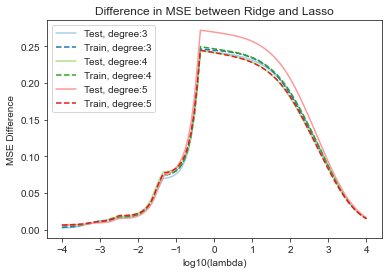

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set_style("ticks")
palette = sns.color_palette("Paired")
sns.set_palette(palette)

# Making the R2 and MSE functions
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)
def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

# Generating the data set
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x, y)
def FrankeFunction(x, y):
    term1 = 0.75 * np.exp(-(0.25 * (9 * x - 2) ** 2) - 0.25 * ((9 * y - 2) ** 2))
    term2 = 0.75 * np.exp(-((9 * x + 1) ** 2) / 49.0 - 0.1 * (9 * y + 1))
    term3 = 0.5 * np.exp(-(9 * x - 7) ** 2 / 4.0 - 0.25 * ((9 * y - 3) ** 2))
    term4 = -0.2 * np.exp(-(9 * x - 4) ** 2 - (9 * y - 7) ** 2)
    return term1 + term2 + term3 + term4

noise = 0
z = FrankeFunction(x, y) + noise * np.random.randn(20) # the additional term is the noise. Adjust the factor by a small number (<<1)

# Making the data into lists
x_flat = x.flatten()
y_flat = y.flatten()
z_flat = z.flatten()

def fit(degree_x, degree_y):
    X = np.zeros((len(x_flat), (degree_x+1)*(degree_y+1)))
    col_idx = 0
    for i in range(degree_x + 1):
        for j in range(degree_y + 1):
            X[:, col_idx] = x_flat**i * y_flat**j
            col_idx += 1
    X_train, X_test, z_train, z_test = train_test_split(X, z_flat, test_size=0.2)
    I = np.eye((degree_x+1)*(degree_y+1),(degree_x+1)*(degree_y+1))
    nlambdas = 100
    MSERidgePredict = np.zeros(nlambdas)
    MSERidgeTrain = np.zeros(nlambdas)
    MSELassoPredict = np.zeros(nlambdas)
    MSELassoTrain = np.zeros(nlambdas)
    MSEdiffPredict = np.zeros(nlambdas)
    MSEdiffTrain = np.zeros(nlambdas)
    
    lambdas = np.logspace(-4, 4, nlambdas)
    for i in range(nlambdas):
        lmb = lambdas[i]
        
        #Ridge
        Ridgebeta = np.linalg.inv(X_train.T @ X_train+lmb*I) @ X_train.T @ z_train
        ztildeRidge = X_train @ Ridgebeta
        zpredictRidge = X_test @ Ridgebeta
        MSERidgePredict[i] = MSE(z_test, zpredictRidge)
        MSERidgeTrain[i] = MSE(z_train, ztildeRidge)
        
        #Lasso
        RegLasso = linear_model.Lasso(lmb,fit_intercept=False)
        RegLasso.fit(X_train, z_train)
        ztildeLasso = RegLasso.predict(X_train)
        zpredictLasso = RegLasso.predict(X_test)
        MSELassoPredict[i] = MSE(z_test,zpredictLasso)
        MSELassoTrain[i] = MSE(z_train,ztildeLasso)
        
        #Difference
        MSEdiffPredict[i] = MSELassoPredict[i] - MSERidgePredict[i]
        MSEdiffTrain[i] = MSELassoTrain[i] - MSERidgeTrain[i]
    
    #Plotting
    plt.plot(np.log10(lambdas), MSEdiffPredict, label = 'Test, degree:' + str(degree_x))
    plt.plot(np.log10(lambdas), MSEdiffTrain, linestyle = '--', label = 'Train, degree:' + str(degree_x))

fit(3,3)
fit(4,4)
fit(5,5)
plt.xlabel('log10(lambda)')
plt.ylabel('MSE Difference')
plt.title('Difference in MSE between Ridge and Lasso')
plt.legend()
plt.show()

### Part d): Paper and pencil part

This exercise deals with various mean values and variances in  linear regression method (here it may be useful to look up chapter 3, equation (3.8) of [Trevor Hastie, Robert Tibshirani, Jerome H. Friedman, The Elements of Statistical Learning, Springer](https://www.springer.com/gp/book/9780387848570)). The exercise is also part of the weekly exercises for week 37.

The assumption we have made is 
that there exists a continuous function $f(\boldsymbol{x})$ and  a normal distributed error $\boldsymbol{\varepsilon}\sim N(0, \sigma^2)$
which describes our data

$$
\boldsymbol{y} = f(\boldsymbol{x})+\boldsymbol{\varepsilon}
$$

We then approximate this function $f(\boldsymbol{x})$ with our model $\boldsymbol{\tilde{y}}$ from the solution of the linear regression equations (ordinary least squares OLS), that is our
function $f$ is approximated by $\boldsymbol{\tilde{y}}$ where we minimized  $(\boldsymbol{y}-\boldsymbol{\tilde{y}})^2$, with

$$
\boldsymbol{\tilde{y}} = \boldsymbol{X}\boldsymbol{\beta}.
$$

The matrix $\boldsymbol{X}$ is the so-called design or feature matrix. 

Show that  the expectation value of $\boldsymbol{y}$ for a given element $i$

$$
\mathbb{E}(y_i)  =\sum_{j}x_{ij} \beta_j=\mathbf{X}_{i, \ast} \, \boldsymbol{\beta},
$$

and that
its variance is

$$
\mbox{Var}(y_i)  = \sigma^2.
$$

Hence, $y_i \sim N( \mathbf{X}_{i, \ast} \, \boldsymbol{\beta}, \sigma^2)$, that is $\boldsymbol{y}$ follows a normal distribution with 
mean value $\boldsymbol{X}\boldsymbol{\beta}$ and variance $\sigma^2$.

With the OLS expressions for the optimal parameters $\boldsymbol{\hat{\beta}}$ show that

$$
\mathbb{E}(\boldsymbol{\hat{\beta}}) = \boldsymbol{\beta}.
$$

Show finally that the variance of $\boldsymbol{\beta}$ is

$$
\mbox{Var}(\boldsymbol{\hat{\beta}}) = \sigma^2 \, (\mathbf{X}^{T} \mathbf{X})^{-1}.
$$

We can use the last expression when we define a so-called confidence interval for the parameters $\beta$. 
A given parameter $\beta_j$ is given by the diagonal matrix element of the above matrix.

### Part e): Bias-variance trade-off and resampling techniques

Our aim here is to study the bias-variance trade-off by implementing the **bootstrap** resampling technique.
**We will only use the simpler ordinary least squares here**.

With a code which does OLS and includes resampling techniques, 
we will now discuss the bias-variance trade-off in the context of
continuous predictions such as regression. However, many of the
intuitions and ideas discussed here also carry over to classification
tasks and basically all Machine Learning algorithms. 

Before you perform an analysis of the bias-variance trade-off on your test data, make
first a figure similar to Fig. 2.11 of Hastie, Tibshirani, and
Friedman. Figure 2.11 of this reference displays only the test and training MSEs. The test MSE can be used to 
indicate possible regions of low/high bias and variance. You will most likely not get an
equally smooth curve!

With this result we move on to the bias-variance trade-off analysis.

Consider a
dataset $\mathcal{L}$ consisting of the data
$\mathbf{X}_\mathcal{L}=\{(y_j, \boldsymbol{x}_j), j=0\ldots n-1\}$.

As in part d), we assume that the true data is generated from a noisy model

$$
\boldsymbol{y}=f(\boldsymbol{x}) + \boldsymbol{\epsilon}.
$$

Here $\epsilon$ is normally distributed with mean zero and standard
deviation $\sigma^2$.

In our derivation of the ordinary least squares method we defined then
an approximation to the function $f$ in terms of the parameters
$\boldsymbol{\beta}$ and the design matrix $\boldsymbol{X}$ which embody our model,
that is $\boldsymbol{\tilde{y}}=\boldsymbol{X}\boldsymbol{\beta}$.

The parameters $\boldsymbol{\beta}$ are in turn found by optimizing the mean
squared error via the so-called cost function

$$
C(\boldsymbol{X},\boldsymbol{\beta}) =\frac{1}{n}\sum_{i=0}^{n-1}(y_i-\tilde{y}_i)^2=\mathbb{E}\left[(\boldsymbol{y}-\boldsymbol{\tilde{y}})^2\right].
$$

Here the expected value $\mathbb{E}$ is the sample value. 

Show that you can rewrite  this in terms of a term which contains the variance of the model itself (the so-called variance term), a
term which measures the deviation from the true data and the mean value of the model (the bias term) and finally the variance of the noise.
That is, show that

$$
\mathbb{E}\left[(\boldsymbol{y}-\boldsymbol{\tilde{y}})^2\right]=(\mathrm{Bias}[\tilde{y}])^2+\mathrm{var}[\tilde{f}]+\sigma^2,
$$

with

$$
(\mathrm{Bias}[\tilde{y}])^2=\left(\boldsymbol{y}-\mathbb{E}\left[\boldsymbol{\tilde{y}}\right]\right)^2,
$$

and

$$
\mathrm{var}[\tilde{f}]=\frac{1}{n}\sum_i(\tilde{y}_i-\mathbb{E}\left[\boldsymbol{\tilde{y}}\right])^2.
$$

The answer to this exercise should be included in the theory part of the report.  This exercise is also part of the weekly exercises of week 37.
Explain what the terms mean and discuss their interpretations.

Perform then a bias-variance analysis of the Franke function by
studying the MSE value as function of the complexity of your model.

Discuss the bias and variance trade-off as function
of your model complexity (the degree of the polynomial) and the number
of data points, and possibly also your training and test data using the **bootstrap** resampling method.
You can follow the code example in the jupyter-book at <https://compphysics.github.io/MachineLearning/doc/LectureNotes/_build/html/chapter3.html#the-bias-variance-tradeoff>.

### Part f):  Cross-validation as resampling techniques, adding more complexity

The aim here is to write your own code for another widely popular
resampling technique, the so-called cross-validation method.  

Implement the $k$-fold cross-validation algorithm (write your own
code) and evaluate again the MSE function resulting
from the test folds. You can compare your own code with that from
**Scikit-Learn** if needed. 

Compare the MSE you get from your cross-validation code with the one
you got from your **bootstrap** code. Comment your results. Try $5-10$
folds.  You can also compare your own cross-validation code with the
one provided by **Scikit-Learn**.

In addition to using the ordinary least squares method, you should include both Ridge and Lasso regression.

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import make_scorer, mean_squared_error
import seaborn as sns
sns.set_style("ticks")
palette = sns.color_palette("Paired")
sns.set_palette(palette)


def KFoldCV(X,z, lmb, model, kfold):
    OLS = LinearRegression()
    ridge = Ridge(lmb, fit_intercept= False)
    lasso = Lasso(lmb, fit_intercept = False, tol = 0.01)
    
    scores_KFold = np.zeros(kfold.get_n_splits(X))
    
    
    j = 0
    for train_inds, test_inds in kfold.split(X):
       
        
        xtrain = X[train_inds]
        ytrain = z[train_inds]
        
        xtest = X[test_inds]
        ytest = z[test_inds]
       
        
        if(model == "OLS"):
            OLS.fit(xtrain, ytrain)
            ypred = OLS.predict(xtest)
        if(model == "Ridge"):
            #Xtrain = poly.fit_transform(xtrain[:, np.newaxis].reshape(xtrain.shape))
            ridge.fit(xtrain, ytrain)
            #Xtest = poly.fit_transform(xtest[:, np.newaxis].reshape(xtest.shape))
            ypred = ridge.predict(xtest)
        if(model == "Lasso"):
            #Xtrain = poly.fit_transform(xtrain[:, np.newaxis].reshape(xtrain.shape))
            lasso.fit(xtrain, ytrain)
            ypred = lasso.predict(xtest)
            #Xtest = poly.fit_transform(xtest[:, np.newaxis].reshape(xtest.shape))
        
        scores_KFold[j] = np.sum((ypred - ytest)**2)/np.size(ypred)
        
        j += 1
    MSE = np.mean(scores_KFold)
    return(MSE)

# Making the R2 and MSE functions
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)
def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

# Generating the data set
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x, y)
def FrankeFunction(x, y):
    term1 = 0.75 * np.exp(-(0.25 * (9 * x - 2) ** 2) - 0.25 * ((9 * y - 2) ** 2))
    term2 = 0.75 * np.exp(-((9 * x + 1) ** 2) / 49.0 - 0.1 * (9 * y + 1))
    term3 = 0.5 * np.exp(-(9 * x - 7) ** 2 / 4.0 - 0.25 * ((9 * y - 3) ** 2))
    term4 = -0.2 * np.exp(-(9 * x - 4) ** 2 - (9 * y - 7) ** 2)
    return term1 + term2 + term3 + term4

noise = 0
z = FrankeFunction(x, y) + noise * np.random.randn(20) # the additional term is the noise. Adjust the factor by a small number (<<1)

# Making the data into lists
x_flat = x.flatten()
y_flat = y.flatten()
z_flat = z.flatten()



def fit(degree_x, degree_y):
    X = np.zeros((len(x_flat), (degree_x+1)*(degree_y+1)))
    poly = PolynomialFeatures(degree = degree_x)
    k = 5
    kfold = KFold(n_splits = k, shuffle=True, random_state = 42)
    col_idx = 0
    for i in range(degree_x + 1):
        for j in range(degree_y + 1):
            X[:, col_idx] = x_flat**i * y_flat**j
            col_idx += 1
    X_train, X_test, z_train, z_test = train_test_split(X, z_flat, test_size=0.2)
    
    
    
    
    I = np.eye((degree_x+1)*(degree_y+1),(degree_x+1)*(degree_y+1))
    nlambdas = 100
    
    MSERidgePredict = np.zeros(nlambdas)
    MSERidgeTrain = np.zeros(nlambdas)
    MSELassoPredict = np.zeros(nlambdas)
    MSELassoTrain = np.zeros(nlambdas)
    MSEdiffPredict = np.zeros(nlambdas)
    MSEdiffTrain = np.zeros(nlambdas)
    
    MSEOLS = np.zeros(nlambdas)
    MSERidge = np.zeros(nlambdas)
    MSELasso = np.zeros(nlambdas)
    
    MSEKFold_OLS = np.zeros(nlambdas)
    MSEKFold_ridge = np.zeros((nlambdas))
    MSEKFold_lasso = np.zeros(nlambdas)
    lambdas = np.logspace(-10, 4, nlambdas)
    for i in range(nlambdas):
        
        lmb = lambdas[i]
        
        #models
        linreg = LinearRegression()
        ridge = Ridge(lmb, fit_intercept = False)
        lasso = Lasso(lmb, fit_intercept = False, tol = 0.01)
        
        #scorings
        
        #XCV = poly.fit_transform(X[:, np.newaxis].reshape(X.shape))
        mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
        linscores = cross_val_score(linreg, X_train, z_train, scoring=mse_scorer,  cv = kfold)
        ridgescores = cross_val_score(ridge, X_train, z_train, scoring=mse_scorer, cv = kfold)
        #lassoscores = cross_validate(lasso, X_train, z_train, scoring=mse_scorer, return_estimator = True, cv = kfold)
        
        #printing scores of CV for sklearn
        #print("OLS: " + str(linscores["test_score"].mean()))
        #print("Ridge: " + str(ridgescores["test_score"].mean()))
        #print("Lasso: " + str(lassoscores["test_score"].mean()))
        
        #storing scores of CV from sklearn
        MSEOLS[i] = np.mean(-linscores)
        MSERidge[i] = np.mean(-ridgescores)
        #MSELasso[i] = -lassoscores["test_score"].mean()
        
        
        #OLS
        #MSEKFold_OLS[i] = KFoldCV(X_train, z_train, lmb, "OLS", kfold)
        
        #Ridge
        
        MSEKFold_ridge[i] = KFoldCV(X_train, z_train, lmb, "Ridge", kfold)
        
        """
        ridge = Ridge(lmb)
        Ridgebeta = np.linalg.inv(X_train.T @ X_train+lmb*I) @ X_train.T @ z_train
        ztildeRidge = X_train @ Ridgebeta
        zpredictRidge = X_test @ Ridgebeta
        MSERidgePredict[i] = MSE(z_test, zpredictRidge)
        MSERidgeTrain[i] = MSE(z_train, ztildeRidge)
        #MSEKFold_ridge[i] = KFoldCV(X_train, z_train, lmb, "Ridge", k)
        """
        #Lasso
        
        #MSEKFold_lasso[i] = KFoldCV(X_train, z_train, lmb, "Lasso", kfold)
        """
        RegLasso = linear_model.Lasso(lmb,fit_intercept=False)
        RegLasso.fit(X_train, z_train)
        ztildeLasso = RegLasso.predict(X_train)
        zpredictLasso = RegLasso.predict(X_test)
        MSELassoPredict[i] = MSE(z_test,zpredictLasso)
        MSELassoTrain[i] = MSE(z_train,ztildeLasso)
        """
        #Difference
        #MSEdiffPredict[i] = MSELassoPredict[i] - MSERidgePredict[i]
        #MSEdiffTrain[i] = MSELassoTrain[i] - MSERidgeTrain[i]
        
    #Plotting
    #plt.plot(np.log10(lambdas), MSEdiffPredict, label = 'Test, degree:' + str(degree_x))
    #plt.plot(np.log10(lambdas), MSEdiffTrain, linestyle = '--', label = 'Train, degree:' + str(degree_x))
    
    #plt.plot(np.log10(lambdas), MSEOLS, label = 'OLS' + str(degree_x))
    #plt.plot(np.log10(lambdas), MSEKFold_OLS, 'x-', label = 'OLS_KFold' + str(degree_x))
    
    plt.plot(np.log10(lambdas), MSERidge, label = 'Ridge' + str(degree_x))
    plt.plot(np.log10(lambdas), MSEKFold_ridge, 'x-', label = 'Ridge_KFold' + str(degree_x))
    
    #plt.plot(np.log10(lambdas), MSELasso, 'x-', label = "Lasso")
    #plt.plot(np.log10(lambdas), MSEKFold_lasso, label = 'Lasso_KFold')
    print(np.min(MSEOLS), np.min(MSERidge), np.min(MSELasso))



for n in range(3,6):
    fit(n,n)
plt.xlabel('log10($\lambda$)')
plt.ylabel('MSE')
plt.title('MSE of KFold and cross_val_score')
plt.legend()
plt.show()

### Part g): Analysis of real data

With our codes functioning and having been tested properly on a
simpler function we are now ready to look at real data. We will
essentially repeat in this exercise what was done in exercises a-f. However, we
need first to download the data and prepare properly the inputs to our
codes.  We are going to download digital terrain data from the website
<https://earthexplorer.usgs.gov/>,

Or, if you prefer, we have placed selected datafiles at <https://github.com/CompPhysics/MachineLearning/tree/master/doc/Projects/2023/Project1/DataFiles>

In order to obtain data for a specific region, you need to register as
a user (free) at this website and then decide upon which area you want
to fetch the digital terrain data from.  In order to be able to read
the data properly, you need to specify that the format should be **SRTM
Arc-Second Global** and download the data as a **GeoTIF** file.  The
files are then stored in *tif* format which can be imported into a
Python program using

In [2]:
scipy.misc.imread

Here is a simple part of a Python code which reads and plots the data
from such files

C:\Users\IFE12739\AppData\Local\Temp\ipykernel_12400\319327851.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  terrain1 = imread('SRTM_data_Norway_1.tif')


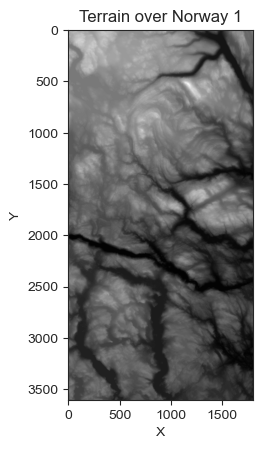

In [78]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Load the terrain
terrain1 = imread('SRTM_data_Norway_1.tif')
# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain1, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Oct  3 15:02:05 2023

@author: erlendou
"""
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
from numpy.random import normal, uniform
from sklearn.metrics import make_scorer, mean_squared_error


def KFoldCV(X,z, lmb, model, kfold):
    OLS = LinearRegression()
    ridge = Ridge(lmb, fit_intercept= False)
    lasso = Lasso(lmb, fit_intercept = False,tol = 0.01)
    
    scores_KFold = np.zeros(kfold.get_n_splits(X))
    
    
    j = 0
    for train_inds, test_inds in kfold.split(X):
       
        
        xtrain = X[train_inds]
        ytrain = z[train_inds]
        
        xtest = X[test_inds]
        ytest = z[test_inds]
       
        
        if(model == "OLS"):
            OLS.fit(xtrain, ytrain)
            ypred = OLS.predict(xtest)
        if(model == "Ridge"):
            #Xtrain = poly.fit_transform(xtrain[:, np.newaxis].reshape(xtrain.shape))
            ridge.fit(xtrain, ytrain)
            #Xtest = poly.fit_transform(xtest[:, np.newaxis].reshape(xtest.shape))
            ypred = ridge.predict(xtest)
        if(model == "Lasso"):
            #Xtrain = poly.fit_transform(xtrain[:, np.newaxis].reshape(xtrain.shape))
            lasso.fit(xtrain, ytrain)
            ypred = lasso.predict(xtest)
            #Xtest = poly.fit_transform(xtest[:, np.newaxis].reshape(xtest.shape))
        
        scores_KFold[j] = np.sum((ypred - ytest)**2)/np.size(ypred)
        
        j += 1
    MSE = np.mean(scores_KFold)
    return(MSE)

# Load the terrain
terrain = imread('SRTM_data_Norway_1.tif')
#terrain2 = imread('SRTM_data_Norway_2.tif')

N = 1000
#m = 5 # polynomial order
terrain = terrain[:N,:N]
# Creates mesh of image pixels
x = np.linspace(0,1, np.shape(terrain)[0])
y = np.linspace(0,1, np.shape(terrain)[1])
x_mesh, y_mesh = np.meshgrid(x,y)

x_flat = x_mesh.flatten()
y_flat = y_mesh.flatten()

z = terrain
z_flat = z.flatten()
#X = create_X(x_mesh, y_mesh,m)

# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# 3D plot 

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
ax.plot_surface(x_mesh,y_mesh,z, cmap = cm.coolwarm, linewidth = 0, antialiased = False)
plt.show()

def fit(degree_x, degree_y):
    k = 5
    X = np.zeros((len(x_flat), (degree_x+1)*(degree_y+1)))
    col_idx = 0
    for i in range(degree_x + 1):
        for j in range(degree_y + 1):
            X[:, col_idx] = x_flat**i * y_flat**j
            col_idx += 1
    
    X_train, X_test, z_train, z_test = train_test_split(X, z_flat, test_size=0.2)        

 
   
    kfold = KFold(n_splits = k, shuffle=True, random_state = 42)
    nlambdas = 10
    
    lambdas = np.logspace(-10,5, nlambdas)
    
    MSEOLSSK = np.zeros(nlambdas)
    MSERidge = np.zeros(nlambdas)
    MSERidgeSK = np.zeros(nlambdas)
    MSELassoSK = np.zeros(nlambdas)
    
    MSEOLS = np.zeros(nlambdas)
    MSERidge = np.zeros(nlambdas)
    MSELasso = np.zeros(nlambdas)
    
    for i in range (len(lambdas)):
        lmb = lambdas[i]
        linreg = LinearRegression()
        ridge = Ridge(lmb)
        lasso = Lasso(lmb, fit_intercept = False, tol=0.01)
        
        
        #MSERidge[i] = KFoldCV(X_train, z_train, lmb, "Ridge", k, degree_x)
        scoring = "neg_root_mean_squared_error"
        mse_score = make_scorer(mean_squared_error, greater_is_better = False)
        OLSscores = cross_val_score(linreg, X_train, z_train, scoring=mse_score, cv = kfold)
        #ridgescores = cross_val_score(ridge, X_train, z_train, scoring=mse_score, cv = kfold)
        #lassoscores = cross_val_score(lasso, X_train, z_train, scoring=mse_score, cv = kfold)
        #MSERidgeSK[i] = np.mean(-ridgescores)
        #MSEOLSSK[i] = np.mean(-OLSscores)
        #MSELassoSK[i] = np.mean(-lassoscores)
        
        MSEOLS[i] = KFoldCV(X_train,z_train, lmb, "OLS", kfold)
        #MSERidge[i] = KFoldCV(X_train,z_train, lmb, "Ridge", kfold)
        #MSELasso[i] = KFoldCV(X_train,z_train, lmb, "Lasso", kfold)
        
        
        print(MSERidge[i],MSERidgeSK[i])
    #Plotting the fit (this is just to illustrate, not part of the exercise. Can therefore be removed)
    plt.plot(degree_x, MSEOLS)
    plt.plot(degree_x, MSEOLSSK)
    
    return(MSE[i])
    
    
    """
    beta = np.linalg.inv(X.T @ X) @ X.T @ z_flat
    ztilde = X @ beta
    ztilde_grid = ztilde.reshape(x_mesh.shape)
    
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(projection='3d')
    surf = ax2.plot_surface(x_mesh, y_mesh, ztilde_grid, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    #ax2.set_zlim(-0.10, 1.40)
    ax2.zaxis.set_major_locator(LinearLocator(10))
    ax2.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    fig2.colorbar(surf, shrink=0.5, aspect=5)
    ax2.set_xlabel('x-axis')
    ax2.set_ylabel('y-axis')
    ax2.set_zlabel('z-axis')
    ax2.set_title('Fitted Terrain: Polynomial degree x' + str(degree_x)+ ', y'+ str(degree_y))
    plt.show()
    """
    
x_deg, y_deg, MSE = [], [], []    

for ni in range(1,6):
    for nj in range(1,6):
        fit(ni,nj)
        
        
        
plt.legend()
plt.show()

FileNotFoundError: No such file: 'C:\Users\erlendou\SRTM_data_Norway_2.tif'

If you should have problems in downloading the digital terrain data,
we provide two examples under the data folder of project 1. One is
from a region close to Stavanger in Norway and the other Møsvatn
Austfjell, again in Norway.
Feel free to produce your own terrain data.

Alternatively, if you would like to use another data set, feel free to do so. This could be data close to your reseach area or simply a data set you found interesting. See for example [kaggle.com](https://www.kaggle.com/datasets) for examples.

Our final part deals with the parameterization of your digital terrain
data (or your own data).  We will apply all three methods for linear regression, the same type (or higher order) of polynomial
approximation and cross-validation as resampling technique to evaluate which
model fits the data best.

At the end, you should present a critical evaluation of your results
and discuss the applicability of these regression methods to the type
of data presented here (either the terrain data we propose or other data sets).

## Background literature

1. For a discussion and derivation of the variances and mean squared errors using linear regression, see the [Lecture notes on ridge regression by Wessel N. van Wieringen](https://arxiv.org/abs/1509.09169)

2. The textbook of [Trevor Hastie, Robert Tibshirani, Jerome H. Friedman, The Elements of Statistical Learning, Springer](https://www.springer.com/gp/book/9780387848570), chapters 3 and 7 are the most relevant ones for the analysis here.

## Introduction to numerical projects

Here follows a brief recipe and recommendation on how to answer the various questions when preparing your answers. 

  * Give a short description of the nature of the problem and the eventual  numerical methods you have used.

  * Describe the algorithm you have used and/or developed. Here you may find it convenient to use pseudocoding. In many cases you can describe the algorithm in the program itself.

  * Include the source code of your program. Comment your program properly. You should have the code at your GitHub/GitLab link. You can also place the code in an appendix of your report.

  * If possible, try to find analytic solutions, or known limits in order to test your program when developing the code.

  * Include your results either in figure form or in a table. Remember to        label your results. All tables and figures should have relevant captions        and labels on the axes.

  * Try to evaluate the reliabilty and numerical stability/precision of your results. If possible, include a qualitative and/or quantitative discussion of the numerical stability, eventual loss of precision etc.

  * Try to give an interpretation of you results in your answers to  the problems.

  * Critique: if possible include your comments and reflections about the  exercise, whether you felt you learnt something, ideas for improvements and  other thoughts you've made when solving the exercise. We wish to keep this course at the interactive level and your comments can help us improve it.

  * Try to establish a practice where you log your work at the  computerlab. You may find such a logbook very handy at later stages in your work, especially when you don't properly remember  what a previous test version  of your program did. Here you could also record  the time spent on solving the exercise, various algorithms you may have tested or other topics which you feel worthy of mentioning.

## Format for electronic delivery of report and programs

The preferred format for the report is a PDF file. You can also use DOC or postscript formats or as an ipython notebook file.  As programming language we prefer that you choose between C/C++, Fortran2008, Julia or Python. The following prescription should be followed when preparing the report:

  * Use Canvas to hand in your projects, log in  at  <https://www.uio.no/english/services/it/education/canvas/> with your normal UiO username and password.

  * Upload **only** the report file or the link to your GitHub/GitLab or similar typo of  repos!  For the source code file(s) you have developed please provide us with your link to your GitHub/GitLab or similar  domain.  The report file should include all of your discussions and a list of the codes you have developed.  Do not include library files which are available at the course homepage, unless you have made specific changes to them.

  * In your GitHub/GitLab or similar repository, please include a folder which contains selected results. These can be in the form of output from your code for a selected set of runs and input parameters.

Finally, 
we encourage you to collaborate. Optimal working groups consist of 
2-3 students. You can then hand in a common report.

## Software and needed installations

If you have Python installed (we recommend Python3) and you feel pretty familiar with installing different packages, 
we recommend that you install the following Python packages via **pip** as
1. pip install numpy scipy matplotlib ipython scikit-learn tensorflow sympy pandas pillow

For Python3, replace **pip** with **pip3**.

See below for a discussion of **tensorflow** and **scikit-learn**. 

For OSX users we recommend also, after having installed Xcode, to install **brew**. Brew allows 
for a seamless installation of additional software via for example
1. brew install python3

For Linux users, with its variety of distributions like for example the widely popular Ubuntu distribution
you can use **pip** as well and simply install Python as 
1. sudo apt-get install python3  (or python for python2.7)

etc etc. 

If you don't want to install various Python packages with their dependencies separately, we recommend two widely used distrubutions which set up  all relevant dependencies for Python, namely
1. [Anaconda](https://docs.anaconda.com/) Anaconda is an open source distribution of the Python and R programming languages for large-scale data processing, predictive analytics, and scientific computing, that aims to simplify package management and deployment. Package versions are managed by the package management system **conda**

2. [Enthought canopy](https://www.enthought.com/product/canopy/)  is a Python distribution for scientific and analytic computing distribution and analysis environment, available for free and under a commercial license.

Popular software packages written in Python for ML are

* [Scikit-learn](http://scikit-learn.org/stable/), 

* [Tensorflow](https://www.tensorflow.org/),

* [PyTorch](http://pytorch.org/) and 

* [Keras](https://keras.io/).

These are all freely available at their respective GitHub sites. They 
encompass communities of developers in the thousands or more. And the number
of code developers and contributors keeps increasing.